In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os

path = '/content/drive/MyDrive/Neural Networks final'

if os.path.exists(path):
    print(f"Folder '{path}' found!")
else:
    print(f"Folder '{path}' not found. Please check the path.")


Mounted at /content/drive
Folder '/content/drive/MyDrive/Neural Networks final' found!


In [2]:
import pandas as pd

In [3]:
dataset = pd.read_csv(f"{path}/CP_Weather.csv", encoding="latin1")


Standard LSTM

First, we tried a standard LSTM using the PyTorch LSTM Module to get a baseline

In [ ]:
import torch
import torch.nn as nn

class StandardWeatherPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardWeatherPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_output = out[:, -1, :]
        output = self.fc(last_output)
        return output

#test usage
input_size = 5
hidden_size = 16
output_size = 4

standard_model = StandardWeatherPredictor(input_size, hidden_size, output_size)
print(standard_model)


StandardWeatherPredictor(
  (lstm): LSTM(5, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


dataset['STATION'] = dataset['STATION'].astype('category').cat.codes
dataset['NAME'] = dataset['NAME'].astype('category').cat.codes

features = dataset[['STATION', 'NAME', 'YEAR', 'MONTH', 'DAY']].values
targets  = dataset[['TMAX', 'TMIN']].values


features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42
)


feat_scaler = StandardScaler()
target_scaler = StandardScaler()

features_train_scaled = feat_scaler.fit_transform(features_train)
targets_train_scaled  = target_scaler.fit_transform(targets_train)

features_test_scaled = feat_scaler.transform(features_test)
targets_test_scaled  = target_scaler.transform(targets_test)


def create_sequences(features, targets, seq_len):
    X_seq = []
    y_seq = []

    for i in range(len(features) - seq_len + 1):
        X_seq.append(features[i:i+seq_len])
        y_seq.append(targets[i+seq_len-1])
    return np.array(X_seq), np.array(y_seq)
seq_len = 10

X_train_seq, y_train_seq = create_sequences(features_train_scaled, targets_train_scaled, seq_len)
X_test_seq, y_test_seq   = create_sequences(features_test_scaled, targets_test_scaled, seq_len)


X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_seq, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = StandardWeatherPredictor(input_size=5, hidden_size=16, output_size=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_loss:.4f}")

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * x_batch.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/50 -- Train Loss: 0.8967
Epoch 2/50 -- Train Loss: 0.4576
Epoch 3/50 -- Train Loss: 0.2290
Epoch 4/50 -- Train Loss: 0.2097
Epoch 5/50 -- Train Loss: 0.2076
Epoch 6/50 -- Train Loss: 0.2073
Epoch 7/50 -- Train Loss: 0.2068
Epoch 8/50 -- Train Loss: 0.2064
Epoch 9/50 -- Train Loss: 0.2056
Epoch 10/50 -- Train Loss: 0.2057
Epoch 11/50 -- Train Loss: 0.2053
Epoch 12/50 -- Train Loss: 0.2047
Epoch 13/50 -- Train Loss: 0.2055
Epoch 14/50 -- Train Loss: 0.2046
Epoch 15/50 -- Train Loss: 0.2047
Epoch 16/50 -- Train Loss: 0.2045
Epoch 17/50 -- Train Loss: 0.2042
Epoch 18/50 -- Train Loss: 0.2041
Epoch 19/50 -- Train Loss: 0.2043
Epoch 20/50 -- Train Loss: 0.2039
Epoch 21/50 -- Train Loss: 0.2041
Epoch 22/50 -- Train Loss: 0.2039
Epoch 23/50 -- Train Loss: 0.2035
Epoch 24/50 -- Train Loss: 0.2036
Epoch 25/50 -- Train Loss: 0.2033
Epoch 26/50 -- Train Loss: 0.2034
Epoch 27/50 -- Train Loss: 0.2034
Epoch 28/50 -- Train Loss: 0.2029
Epoch 29/50 -- Train Loss: 0.2025
Epoch 30/50 -- Train Lo

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score


y_train = train_dataset.tensors[1]

thresholds = torch.median(y_train, dim=0).values

model.eval()
test_loss = 0.0
criterion = torch.nn.MSELoss()

all_preds = []
all_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        all_preds.append(predictions)
        all_true.append(y_batch)

average_test_loss = test_loss / len(test_loader.dataset)
print(f"Test MSE Loss: {average_test_loss:.4f}")

all_preds = torch.cat(all_preds, dim=0)
all_true = torch.cat(all_true, dim=0)

pred_labels = (all_preds > thresholds).int().cpu().numpy()
true_labels = (all_true > thresholds).int().cpu().numpy()

accuracies = []
f1_scores = []

for i in range(2):
    acc = accuracy_score(true_labels[:, i], pred_labels[:, i])
    f1 = f1_score(true_labels[:, i], pred_labels[:, i])
    accuracies.append(acc)
    f1_scores.append(f1)
    print(f"Target {i} -- Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        print("Sample Predictions:", predictions[:5])
        print("Ground Truth:", y_batch[:5])
        break


Test MSE Loss: 0.1996
Target 0 -- Accuracy: 0.8859, F1 Score: 0.8897
Target 1 -- Accuracy: 0.9097, F1 Score: 0.9121
Sample Predictions: tensor([[-0.5938, -0.6882],
        [ 1.1420,  1.1843],
        [-1.2040, -1.2744],
        [-1.3801, -1.4245],
        [ 0.8012,  0.7940]])
Ground Truth: tensor([[-0.1491, -0.2002],
        [ 0.9251,  1.4352],
        [-1.9583, -2.0779],
        [-1.6756, -1.7750],
        [ 0.8120,  1.0112]])


These were our baseline accuracy + F1 scores for the standard LSTM. Accuracy is computed using a somewhat arbitrary threshold since we're predicting continuous values, so the loss is in some ways more informative.

Reversible LSTM + Reversibility Test

Our basic idea was to split the hidden and cell states into halves, as is often done in reversible architectures, such that one can be computed from the other, allowing us to reverse computations.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def leaky_relu_inverse(y, negative_slope=0.01):
    return torch.where(y >= 0, y, y / negative_slope)

class ReversibleLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ReversibleLSTMCell, self).__init__()
        assert hidden_size % 2 == 0, "hidden_size must be even"
        self.hidden_size = hidden_size
        half = hidden_size // 2

        self.i1 = nn.Linear(input_size + half, half)
        self.f1 = nn.Linear(input_size + half, half)
        self.o1 = nn.Linear(input_size + half, half)
        self.g1 = nn.Linear(input_size + half, half)

        self.i2 = nn.Linear(input_size + half, half)
        self.f2 = nn.Linear(input_size + half, half)
        self.o2 = nn.Linear(input_size + half, half)
        self.g2 = nn.Linear(input_size + half, half)

    def forward(self, x, h, c):
        half = self.hidden_size // 2
        h1, h2 = h[:, :half], h[:, half:]
        c1, c2 = c[:, :half], c[:, half:]

        combined1 = torch.cat([x, h2], dim=1)
        i1 = F.leaky_relu(self.i1(combined1))
        f1 = F.softplus(self.f1(combined1)) + 0.1
        o1 = F.leaky_relu(self.o1(combined1))
        g1 = F.leaky_relu(self.g1(combined1))
        c1_new = f1 * c1 + i1 * g1
        #here is the issue-- multiplication massively amplifies differences...
        h1_new = o1 * F.leaky_relu(c1_new)

        combined2 = torch.cat([x, h1_new], dim=1)
        i2 = F.leaky_relu(self.i2(combined2))
        f2 = F.softplus(self.f2(combined2)) + 0.1
        o2 = F.leaky_relu(self.o2(combined2))
        g2 = F.leaky_relu(self.g2(combined2))
        c2_new = f2 * c2 + i2 * g2
        h2_new = o2 * F.leaky_relu(c2_new)

        new_h = torch.cat([h1_new, h2_new], dim=1)
        new_c = torch.cat([c1_new, c2_new], dim=1)
        return new_h, new_c


    def reverse(self, x, new_h, new_c):
        half = self.hidden_size // 2
        h1_new, h2_new = new_h[:, :half], new_h[:, half:]
        c1_new, c2_new = new_c[:, :half], new_c[:, half:]
        combined2 = torch.cat([x, h1_new], dim=1)
        i2 = F.leaky_relu(self.i2(combined2))
        f2 = F.softplus(self.f2(combined2)) + 0.1
        o2 = F.leaky_relu(self.o2(combined2))
        g2 = F.leaky_relu(self.g2(combined2))
        c2 = (c2_new - i2 * g2) / f2
        #any small diffs in cell state are amplified by leaky relu nonlinearity
        #inherently this is gonna be worse than recovering the cell state because h_new does not use h in its computation
        #this means we have to compute it from c_recovered, whereas c_recovered can be computed from c_new
        #so any errors in c_recovered computation massively propagate into h_recovered
        h2 = o2 * F.leaky_relu(c2)

        combined1 = torch.cat([x, h2], dim=1)
        i1 = F.leaky_relu(self.i1(combined1))
        f1 = F.softplus(self.f1(combined1)) + 0.1
        o1 = F.leaky_relu(self.o1(combined1))
        g1 = F.leaky_relu(self.g1(combined1))
        c1 = (c1_new - i1 * g1) / f1
        h1 = o1 * F.leaky_relu(c1)

        h = torch.cat([h1, h2], dim=1)
        c = torch.cat([c1, c2], dim=1)
        return h, c


Additionally, we replaced all sigmoid + tanh activations with leaky ReLu, since sigmoid and tanh are saturating nonlinearities, meaning that they're inherently less easily reversible than something that's piecewise linear like leaky ReLu. We found that this improved reversibility by a significant amount. Leaky ReLu, as oppposed to regular ReLu, was also crucial here because it helped mitigate entering the ReLu dead zone, which was definitely going to be a problem if we had a ton of regular ReLu activations.

In [6]:
class WeatherPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=2):
        super(WeatherPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.rev_cell = ReversibleLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(batch_size, self.hidden_size, device=x.device)
        for t in range(seq_len):
            h, c = self.rev_cell(x[:, t, :], h, c)
        out = self.fc(h)
        return out


We trained only on the min/max temperature data to limit the scope of the project and allow us to focus more on the actual reversibility of the architecture without having to account for so many varied performance targets. We found that sequence length for the chunks that we split the dataset into had little effect, so we just left it at 10. Obviously, we needed sequential data chunks here in order to harness the memory component of an LSTM.

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

dataset['STATION'] = dataset['STATION'].astype('category').cat.codes
dataset['NAME'] = dataset['NAME'].astype('category').cat.codes

features = dataset[['STATION', 'NAME', 'YEAR', 'MONTH', 'DAY']].values
targets  = dataset[['TMAX', 'TMIN']].values

features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42
)

feat_scaler = StandardScaler()
target_scaler = StandardScaler()

features_train_scaled = feat_scaler.fit_transform(features_train)
targets_train_scaled  = target_scaler.fit_transform(targets_train)

features_test_scaled = feat_scaler.transform(features_test)
targets_test_scaled  = target_scaler.transform(targets_test)

def create_sequences(features, targets, seq_len):
    X_seq = []
    y_seq = []
    for i in range(len(features) - seq_len + 1):
        X_seq.append(features[i:i+seq_len])
        y_seq.append(targets[i+seq_len-1])
    return np.array(X_seq), np.array(y_seq)

seq_len = 10

X_train_seq, y_train_seq = create_sequences(features_train_scaled, targets_train_scaled, seq_len)
X_test_seq, y_test_seq   = create_sequences(features_test_scaled, targets_test_scaled, seq_len)


X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_seq, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = WeatherPredictor(input_size=5, hidden_size=16, output_size=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_loss:.4f}")

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * x_batch.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/50 -- Train Loss: 0.8843
Epoch 2/50 -- Train Loss: 0.6029
Epoch 3/50 -- Train Loss: 0.5271
Epoch 4/50 -- Train Loss: 0.4070
Epoch 5/50 -- Train Loss: 0.3190
Epoch 6/50 -- Train Loss: 0.2857
Epoch 7/50 -- Train Loss: 0.2691
Epoch 8/50 -- Train Loss: 0.2566
Epoch 9/50 -- Train Loss: 0.2470
Epoch 10/50 -- Train Loss: 0.2395
Epoch 11/50 -- Train Loss: 0.2333
Epoch 12/50 -- Train Loss: 0.2301
Epoch 13/50 -- Train Loss: 0.2274
Epoch 14/50 -- Train Loss: 0.2247
Epoch 15/50 -- Train Loss: 0.2229
Epoch 16/50 -- Train Loss: 0.2219
Epoch 17/50 -- Train Loss: 0.2203
Epoch 18/50 -- Train Loss: 0.2190
Epoch 19/50 -- Train Loss: 0.2179
Epoch 20/50 -- Train Loss: 0.2168
Epoch 21/50 -- Train Loss: 0.2166
Epoch 22/50 -- Train Loss: 0.2154
Epoch 23/50 -- Train Loss: 0.2153
Epoch 24/50 -- Train Loss: 0.2141
Epoch 25/50 -- Train Loss: 0.2143
Epoch 26/50 -- Train Loss: 0.2140
Epoch 27/50 -- Train Loss: 0.2126
Epoch 28/50 -- Train Loss: 0.2114
Epoch 29/50 -- Train Loss: 0.2116
Epoch 30/50 -- Train Lo

In [8]:
import torch
from sklearn.metrics import accuracy_score, f1_score

y_train = train_dataset.tensors[1]

thresholds = torch.median(y_train, dim=0).values

model.eval()
test_loss = 0.0
criterion = torch.nn.MSELoss()

all_preds = []
all_true = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        all_preds.append(predictions)
        all_true.append(y_batch)

average_test_loss = test_loss / len(test_loader.dataset)
print(f"Test MSE Loss: {average_test_loss:.4f}")

all_preds = torch.cat(all_preds, dim=0)
all_true = torch.cat(all_true, dim=0)

pred_labels = (all_preds > thresholds).int().cpu().numpy()
true_labels = (all_true > thresholds).int().cpu().numpy()

accuracies = []
f1_scores = []

for i in range(2):
    acc = accuracy_score(true_labels[:, i], pred_labels[:, i])
    f1 = f1_score(true_labels[:, i], pred_labels[:, i])
    accuracies.append(acc)
    f1_scores.append(f1)
    print(f"Target {i} -- Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        predictions = model(x_batch)
        print("Sample Predictions:", predictions[:5])
        print("Ground Truth:", y_batch[:5])
        break

Test MSE Loss: 0.2073
Target 0 -- Accuracy: 0.8908, F1 Score: 0.8925
Target 1 -- Accuracy: 0.9088, F1 Score: 0.9112
Sample Predictions: tensor([[-0.7174, -0.8352],
        [ 1.2115,  1.2434],
        [-1.2850, -1.3036],
        [-1.3602, -1.4438],
        [ 0.8224,  0.8507]])
Ground Truth: tensor([[-0.1491, -0.2002],
        [ 0.9251,  1.4352],
        [-1.9583, -2.0779],
        [-1.6756, -1.7750],
        [ 0.8120,  1.0112]])


Awesome! We found that our reversible cell maintained similar accuracy scores to the standard LSTM. Now to test for actual reversibility...

Initial Reversibility Test of Cell and Hidden States Over a Single Timestep

Here, we're plotting a histogram of cosine similarities between actual previous hidden states and recovered ones, as well as cell states. We also compute the norm of the difference over each tensor, to give us an idea of the order of magnitude error that our approximation was introducing.

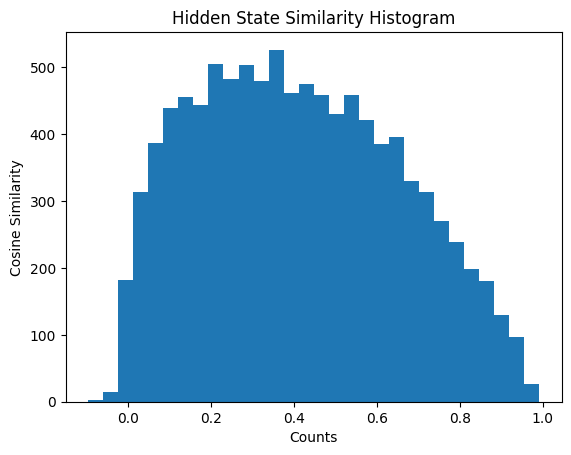

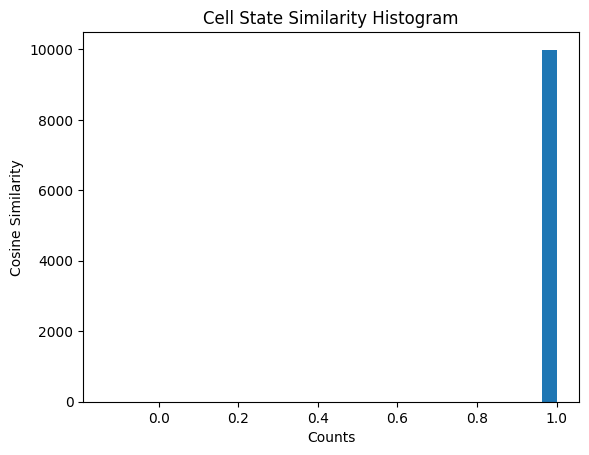

6.87% of the time... it works 100% of the time...


In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

sims = []
sims_cell = []

count = 0
for i in range(10000):
  input_size = 5
  hidden_size = 16
  batch_size = 4
  timesteps = 5

  rev_cell = ReversibleLSTMCell(input_size, hidden_size)

  x_seq = torch.randn(timesteps, batch_size, input_size)
  h0 = torch.randn(batch_size, hidden_size)
  c0 = torch.randn(batch_size, hidden_size)


  #need to do multiple forward passes bc h0 is not computed by the network and thus not recoverable
  forward_states = [(h0, c0)]
  h, c = h0, c0
  for t in range(timesteps):
      h, c = rev_cell(x_seq[t], h, c)
      forward_states.append((h, c))


  h_last, c_last = forward_states[-1]
  x_last = x_seq[timesteps-1]

  recovered_h, recovered_c = rev_cell.reverse(x_last, h_last, c_last)

  orig_h, orig_c = forward_states[-2]

  h_diff = torch.norm(orig_h - recovered_h)
  c_diff = torch.norm(orig_c - recovered_c)
  cos_sim_h = F.cosine_similarity(orig_h.flatten().unsqueeze(0), recovered_h.flatten().unsqueeze(0))
  cos_sim_c = F.cosine_similarity(orig_c.flatten().unsqueeze(0), recovered_c.flatten().unsqueeze(0))
  sims.append(cos_sim_h.item())
  sims_cell.append(cos_sim_c.item())
  if cos_sim_h.item() > 0.8:
    count += 1
  # print(orig_h.tolist())
  # print(recovered_h.tolist())
  # print(f"Difference in hidden state: {h_diff.item():.6f}")
  # print(f"Difference in cell state: {c_diff.item():.6f}")
  # print(f"Cosine similarity of hidden: {cos_sim_h.item()}")
  # print(f"Cosine similarity of cell: {cos_sim_c.item()}")

plt.hist(np.array(sims), density=False, bins=30)
plt.xlabel('Counts')
plt.ylabel('Cosine Similarity')
plt.title('Hidden State Similarity Histogram')
plt.show()

plt.hist(np.array(sims_cell), density=False, bins=30)
plt.xlabel('Counts')
plt.ylabel('Cosine Similarity')
plt.title('Cell State Similarity Histogram')
plt.show()
print(f"{count/10000 * 100}% of the time... it works 100% of the time...")

In attempting to improve reversibility, we narrowed it down to an issue with the line where we compute the hidden state, since the cell state seemed to be recovered just fine. This left us with two options for potential issues: the leaky ReLu activation on cell state, and the output gate recoverability. Removing the leaky ReLu activation on the cell state and making it linear instead (ie, h = o * c) didn't seem to do anything, so we tried to see if our output gates were being effectively recovered.

In [ ]:
import torch
import torch.nn.functional as F


input_size = 5
hidden_size = 16
batch_size = 4
half = hidden_size // 2
rev_cell = ReversibleLSTMCell(input_size, hidden_size)

#burn/random init
x = torch.randn(batch_size, input_size)
h_base = torch.randn(batch_size, hidden_size)
c_base = torch.randn(batch_size, hidden_size)
new_h, new_c = rev_cell(x, h_base, c_base)

#actual
x0 = torch.randn(batch_size, input_size)
h0 = new_h
c0 = new_c
new_h, new_c = rev_cell(x, h0, c0)

recovered_h, recovered_c = rev_cell.reverse(x, new_h, new_c)

h2_fwd = new_h[:, half:]
combined1_fwd = torch.cat([x, h2_fwd], dim=1)
o1_fwd = F.leaky_relu(rev_cell.o1(combined1_fwd))

h1_fwd = new_h[:, :half]
combined2_fwd = torch.cat([x, h1_fwd], dim=1)
o2_fwd = F.leaky_relu(rev_cell.o2(combined2_fwd))

h2_rev = recovered_h[:, half:]
combined1_rev = torch.cat([x, h2_rev], dim=1)
o1_rev = F.leaky_relu(rev_cell.o1(combined1_rev))

h1_rev = recovered_h[:, :half]
combined2_rev = torch.cat([x, h1_rev], dim=1)
o2_rev = F.leaky_relu(rev_cell.o2(combined2_rev))

cos_sim_o1 = F.cosine_similarity(o1_fwd.flatten().unsqueeze(0), o1_rev.flatten().unsqueeze(0))
cos_sim_o2 = F.cosine_similarity(o2_fwd.flatten().unsqueeze(0), o2_rev.flatten().unsqueeze(0))

print("Cosine similarity for output gate o1:", cos_sim_o1.item())
print("Cosine similarity for output gate o2:", cos_sim_o2.item())


Cosine similarity for output gate o1: 0.9996269941329956
Cosine similarity for output gate o2: 0.9992310404777527


As you can see from the above, the output gates were recovered effectively. This left the only source of error as the actual multiplication operation between the activated cell state and the output gate. For the sake of ablation testing, we tried replacing this with an additive operation (ie, h = o + c), and this did indeed improve reversibility, generating < 0.9 cosine similarity scores between actual and recovered hidden states about 90% of the time. However, this gets away from the inherent dynamics of an LSTM, in that the purpose of the Hadamard product operation is to act as an actual gate, causing large effects on the hidden state from the cell state. Adding the two negates the purpose of this, as it only modifies the hidden state by a comparitively small amount wrt the cell state. Thus, we decided to keep the architecture as is, maintaining the characteristics of an LSTM but with only very roughly approximate reversibility.

Max Sequence Length Reversibility Test

Now, we wanted to see how many timesteps we could reverse over.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def test_reversibility_for_seq_length(seq_len, input_size, hidden_size, batch_size=4, burn_in_steps=1):
    rev_cell = ReversibleLSTMCell(input_size, hidden_size)
    h0 = torch.randn(batch_size, hidden_size)
    c0 = torch.randn(batch_size, hidden_size)

    #need to "burn" a forward pass so what we're attempting to recover was something actually generated by the network and not just a bunch of random numbers
    x_burn = torch.randn(batch_size, input_size)
    h_burn, c_burn = rev_cell(x_burn, h0, c0)

    x_seq = torch.randn(seq_len, batch_size, input_size)

    forward_states = [(h_burn, c_burn)]
    h, c = h_burn, c_burn
    for t in range(seq_len):
        h, c = rev_cell(x_seq[t], h, c)
        forward_states.append((h, c))

    recovered_states = [None] * (seq_len + 1)
    recovered_states[seq_len] = forward_states[seq_len]
    for t in range(seq_len, 0, -1):
        h_rec, c_rec = rev_cell.reverse(x_seq[t-1], recovered_states[t][0], recovered_states[t][1])
        recovered_states[t-1] = (h_rec, c_rec)

    h_diff = torch.norm(forward_states[0][0] - recovered_states[0][0])
    c_diff = torch.norm(forward_states[0][1] - recovered_states[0][1])
    h_sim = F.cosine_similarity(torch.tensor(forward_states[0][0]), torch.tensor(recovered_states[0][0]))
    c_sim = F.cosine_similarity(torch.tensor(forward_states[0][1]), torch.tensor(recovered_states[0][1]))

    return h_diff.item(), c_diff.item(), h_sim, c_sim

input_size = 5
hidden_size = 16
batch_size = 4

seq_lengths = [1, 2, 5, 10, 20, 50]
results = {}

print("Testing approximate reversibility over different sequence lengths:")
for seq_len in seq_lengths:
    h_diff, c_diff, h_sim, c_sim = test_reversibility_for_seq_length(seq_len, input_size, hidden_size, batch_size)
    results[seq_len] = (h_diff, c_diff)
    print(f"Sequence Length: {seq_len:2d}  -  Hidden Diff: {h_diff:.6f}, Cell Diff: {c_diff:.6f}")
    print(f"Cosine similarities for length {seq_len:2d}: Hidden: {h_sim}, Cell: {c_sim}")


Testing approximate reversibility over different sequence lengths:
Sequence Length:  1  -  Hidden Diff: 1.200497, Cell Diff: 0.158134
Cosine similarities for length  1: Hidden: tensor([0.3423, 0.9188, 0.9455, 0.9728]), Cell: tensor([0.9995, 0.9999, 1.0000, 1.0000])
Sequence Length:  2  -  Hidden Diff: 1.510800, Cell Diff: 0.678211
Cosine similarities for length  2: Hidden: tensor([0.7313, 0.7748, 0.7284, 0.5034]), Cell: tensor([0.9832, 0.9998, 0.9998, 0.9988])
Sequence Length:  5  -  Hidden Diff: 0.709078, Cell Diff: 0.340351
Cosine similarities for length  5: Hidden: tensor([ 0.1931,  0.8171, -0.3100,  0.7483]), Cell: tensor([0.9999, 0.9985, 0.9947, 0.9997])
Sequence Length: 10  -  Hidden Diff: 1.423560, Cell Diff: 2.077844
Cosine similarities for length 10: Hidden: tensor([ 0.9263,  0.5548,  0.7855, -0.0170]), Cell: tensor([0.9976, 0.9683, 0.9171, 0.9492])
Sequence Length: 20  -  Hidden Diff: 9.677454, Cell Diff: 57.163315
Cosine similarities for length 20: Hidden: tensor([ 0.2348,  

<ipython-input-161-fed916532d91>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_sim = F.cosine_similarity(torch.tensor(forward_states[0][0]), torch.tensor(recovered_states[0][0]))
<ipython-input-161-fed916532d91>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_sim = F.cosine_similarity(torch.tensor(forward_states[0][1]), torch.tensor(recovered_states[0][1]))


As you can see, things get pretty dicey around 20 or so. It seems to do a

decent enough job of reversibly computing hidden states over about 10 timesteps.